In [1]:
import pandas as pd
from glob import glob
import numpy as np
from tools.procOps import *
from tools.fileOps import *
from collections import *
import itertools
from scipy.special import *
from tools.bio import *

In [200]:
# load feature set
ab_site_df = pd.read_csv('merged_features.tsv', sep='\t')

In [201]:
# filter for non C/D/N sites
ab_site_df = ab_site_df[(ab_site_df.C == 0) | (ab_site_df.D == 0) | (ab_site_df.N == 0)]
ab_site_df = ab_site_df.drop(['C', 'D', 'N'], axis=1)
bad_sites = [x for x, y in ab_site_df.set_index('loc').iterrows() if y.sum() == 0]
ab_site_df = ab_site_df[~ab_site_df['loc'].isin(bad_sites)]

In [220]:
# load our training genomes

files = {'H9': '/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/H9.pileup.txt',
      'NA24385': '/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/NA24385.pileup.txt',
      'NA12878': '/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/NA12878.pileup.txt',
      'NA19240': '/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/NA19240.pileup.txt',
        'CHM1': '/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/CHM1.pileup.txt'}

dfs = {g: pd.read_csv(f, sep='\t', index_col=0) for g, f in files.iteritems()}

# load sites
filtered_dfs = {}
for g, df in dfs.iteritems():
    filtered_dfs[g] = df[df['loc'].isin(ab_site_df['loc'])]

In [221]:
# filter the suns for sites in all
seen_sites = set.intersection(*[set(x['loc']) for x in filtered_dfs.itervalues()])

filtered_ab_site_df = ab_site_df[ab_site_df['loc'].isin(seen_sites)]

In [226]:
# load actual data from pileups into actual_alt, synthetic_alt, depth, s
actual_alt = []
depth = []
s_matrix = []  # genotype matrix
f = filtered_ab_site_df.set_index('loc').as_matrix()

ploidy_matrix = {'NA19240': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                'NA12878': [2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                'NA24385': [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                'H9': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
                'CHM1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]}

H = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
             [2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]])

#seen_genomes = set()
for n, df_m in filtered_dfs.items():
    df_m = df_m[df_m['loc'].isin(seen_sites)]
    for _, s in df_m.iterrows():
        actual_alt.append(s.alt_count)
        depth.append(s.coverage)
    # always 4-2-2-2
    s_matrix.append(ploidy_matrix[n])
    #seen_genomes.add(n)


In [227]:
depth = np.array(depth).reshape(5, f.shape[0]).T
actual_alt = np.array(actual_alt).reshape(5, f.shape[0]).T
s = np.array(s_matrix).T
tot = depth.sum(axis=1)

In [228]:
# calculate synthetic depth for all genomes
tsa = (np.multiply(depth, np.dot(f, s)) / H.sum(axis=1)).sum(axis=1)

In [229]:
taa = actual_alt.sum(axis=1)

In [230]:
depth_total = depth.sum(axis=1)

In [231]:
synthetic_alt = []
for h in H:
    synthetic_alt.append(np.multiply(depth_total, np.dot(f, h)) / sum(h))
synthetic_alt = np.array(synthetic_alt)

In [232]:
bias = 1.0 * taa / tsa

In [585]:
# mask bias to 1 for all A/B features
# how does the bias look per unambiguous site? ambiguous?
masked_bias = []
a_sites = set()
for i, b in enumerate(bias):
    site = filtered_ab_site_df.iloc[i]
    total = site.NAB + site.NC + site.ND + site.NN
    if total == 1 and site.NAB == 1:
        a_sites.add(i)
        masked_bias.append(1)
    else:
        masked_bias.append(b)
masked_bias = np.array(masked_bias)

In [641]:
projected_alt = np.multiply(synthetic_alt, bias)
#projected_alt = np.multiply(synthetic_alt, masked_bias)

In [642]:
projected_ref = depth_total - projected_alt

In [643]:
u = projected_alt / (projected_alt + projected_ref)
a_matrix = u * (tot - 1)
b_matrix = (1 - u) * (tot  - 1)

In [644]:
# mix a and b slightly to give noise
delta = 0.01
aprime = (1 - delta) * a_matrix + delta * b_matrix
bprime = (1 - delta) * b_matrix + delta * a_matrix

In [645]:
# now lets try predicting copy number across the whole cohort

def r_fn(aprime, bprime, m, n):
    r_values = []
    for a, b in zip(aprime, bprime):
        r_values.append(np.sum(betaln(m + a, n + b) - betaln(a, b)))
    return r_values

In [646]:
# filter by bias
#bad_sites = set()
#for i, b in enumerate(bias):
#    if not (0.9 < b < 1.1):
#        bad_sites.add(filtered_ab_site_df.iloc[i]['loc'])

In [647]:
results = []
for g, df_m in dfs.iteritems():
    df_m = df_m[(df_m['loc'].isin(filtered_ab_site_df['loc'])) & (~df_m['loc'].isin(bad_sites))]
    m = df_m.alt_count
    n = df_m.ref_count
    r_values = r_fn(aprime, bprime, m, n)
    # figure out which one was the best scoring
    r_map = {i: x for i, x in enumerate(r_values)}
    best_index, score = sorted(r_map.iteritems(), key=lambda x: x[1])[-1]
    best_haps = H[best_index]
    results.append([g] + list(best_haps))

In [648]:
results = pd.DataFrame(results, columns=['genome', 'NAB', 'NC', 'ND', 'NN'])
results = results[~results.genome.isin(bad_genomes)]
results.head()

,genome,NAB,NC,ND,NN
0,SS6004480,4.0,2.0,1.0,3.0
1,LP6005441-DNA_D11,4.0,2.0,1.0,2.0
2,LP6005519-DNA_G02,4.0,2.0,1.0,2.0
3,LP6005519-DNA_G04,4.0,2.0,1.0,2.0
4,LP6005441-DNA_B03,4.0,2.0,1.0,3.0


In [649]:
Counter(results.NAB)

Counter({4.0: 245, 5.0: 19})

In [650]:
Counter(results.NC)

Counter({0.0: 1, 1.0: 17, 2.0: 244, 3.0: 2})

In [651]:
Counter(results.ND)

Counter({0.0: 36, 1.0: 107, 2.0: 120, 3.0: 1})

In [652]:
Counter(results.NN)

Counter({2.0: 208, 3.0: 53, 4.0: 3})

In [653]:
Counter(results.set_index('genome').sum(axis=1))

Counter({7.0: 2, 8.0: 12, 9.0: 95, 10.0: 148, 11.0: 6, 12.0: 1})

In [367]:
# figure out which one was the best scoring
m = df_m.alt_count
n = df_m.ref_count
r_values = r_fn(aprime, bprime, m, n)
# figure out which one was the best scoring
r_map = {i: x for i, x in enumerate(r_values)}
best_index, score = sorted(r_map.iteritems(), key=lambda x: x[1])[-1]
best_haps = H[best_index]
ordered = sorted(r_map.iteritems(), key=lambda x: x[1])[-10:][::-1]
print 'log odds: {}'.format(score)
print ''
print 'results: '
for x, y in zip(ab_site_df.columns[1:], best_haps):
    if y > 0:
        print '{}: {}'.format(x, y)

print ' '.join(ab_site_df.columns[1:])
print 'top 10 hits:'
for i, x in enumerate([[H[pos], pos, val] for pos, val in ordered], 1):
    print '{}: {}'.format(i, x)


log odds: -83474.0862732

results: 
NAB: 4.0
NC: 3.0
ND: 2.0
NN: 2.0
NAB NC ND NN
top 10 hits:
1: [array([ 4.,  3.,  2.,  2.]), 545, -83474.08627319903]
2: [array([ 5.,  3.,  2.,  2.]), 656, -83707.78800432892]
3: [array([ 4.,  4.,  2.,  2.]), 564, -83938.25200824531]
4: [array([ 3.,  3.,  2.,  2.]), 416, -83950.13466311186]
5: [array([ 4.,  2.,  2.,  2.]), 521, -84051.0668517208]
6: [array([ 4.,  3.,  3.,  2.]), 549, -84073.36539367499]
7: [array([ 3.,  2.,  1.,  2.]), 384, -84081.84400771832]
8: [array([ 3.,  2.,  2.,  1.]), 388, -84119.16395575868]
9: [array([ 4.,  3.,  2.,  3.]), 546, -84128.56204784538]
10: [array([ 3.,  3.,  1.,  2.]), 410, -84404.7162094571]


In [422]:
def calculate_deviance(s):
    if s.alt_count == 0 or s.coverage <= 20:
        return None
    deviance = (s.adjusted_alt - s.alt_count) / (np.sqrt(1.0 * s.coverage * s.ratio * (1 - s.ratio)))
    #deviance = (s.expected_alt - s.alt_count) / (np.sqrt(1.0 * s.coverage * s.ratio * (1 - s.ratio)))
    return deviance


def calculate_expected(s, tot):
    """Expected value"""
    expected_ratio = (1.0 * s.NAB + s.NC + s.ND + s.NN) / tot
    return expected_ratio * s.coverage


df = dfs['LP6005592-DNA_H03']
df_m = df.merge(ab_site_df, on='loc')
df_m = df_m[df_m['loc'].isin(filtered_ab_site_df['loc'])]
df_m = df_m[~df_m['loc'].isin(bad_sites)]
df_m['adjusted_alt'] = df_m['alt_count'] * bias
df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=10)
df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)

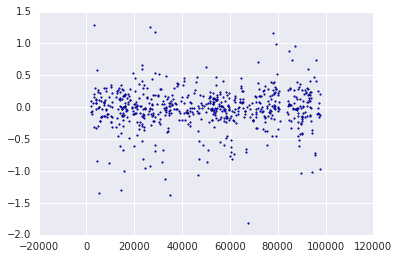

In [423]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(df_m['loc'], df_m['deviance'], s=3)

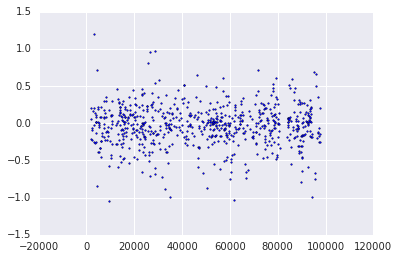

In [351]:
df_m = filtered_dfs['LP6005519-DNA_E06']
df_m = df_m[df_m['loc'].isin(filtered_ab_site_df['loc'])]
df_m = df_m[~df_m['loc'].isin(bad_sites)]
df_m['adjusted_alt'] = df_m['alt_count'] * bias
df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=10)
df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)
plt.scatter(df_m['loc'], df_m['deviance'], s=3)

In [ ]:
positions = set(ab_site_df['loc'])
dev_dfs = {}
for n, df in dfs.iteritems():
    if n not in m:
        continue
    num_c, num_d = m[n]
    tot = 6 + num_c + num_d
    df_m = df.merge(ab_site_df, on='loc')
    df_m['NC'] = [x - (2 - num_c) if x != 0 else x for x in df_m['NC']]
    df_m['ND'] = [x - (2 - num_d) if x != 0 else x for x in df_m['ND']]
    df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=tot)
    df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)
    dev_dfs[n] = df_m

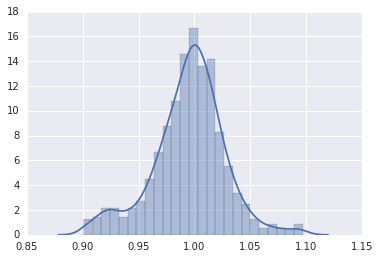

In [343]:
sns.distplot(bias)

In [565]:
# how does the bias look per unambiguous site? ambiguous?
biases = defaultdict(list)
for i, b in enumerate(bias):
    site = filtered_ab_site_df.iloc[i]
    total = site.NAB + site.NC + site.ND + site.NN
    if total == 1:
        if site.NAB == 1:
            biases['AB'].append(b)
        elif site.NC == 1:
            biases['C'].append(b)
        elif site['ND'] == 1:
            biases['D'].append(b)
        elif site['NN'] == 1:
            biases['N'].append(b)
    else:
        biases['ambig'].append(b)

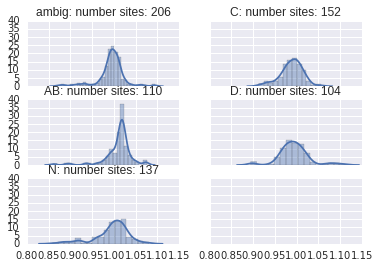

In [571]:
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True)
for ax, b in zip(axes.flat, biases):
    g = sns.distplot(biases[b], ax=ax)
    g.set_title('{}: number sites: {}'.format(b, len(biases[b])))

In [658]:
# save bias vector
import cPickle as pickle
bias_df = []
for i, b in enumerate(bias):
    bias_df.append([filtered_ab_site_df.iloc[i]['loc'], b])
bias_df = pd.DataFrame(bias_df, columns=['loc', 'bias'])
bias_df.to_csv('trained_biases.tsv', sep='\t')

In [ ]:
#for i, b in enumerate(bias):
#    if not (0.9 < b < 1.1):
#        bad_sites.add(filtered_ab_site_df.iloc[i]['loc'])